# Sentiment Analysis on Tweet Data

Credit: Duy Tan LE (David) - Github: @tanle8

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re
from nltk.corpus import stopwords
import nltk
import spacy
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout



In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download stop words
nltk.download('stopwords')

spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Part 1. Data Preparation

## 1.0.  Load the data

In [ ]:
def load_data(file_path):
    # Assuming data is separated by a semicolon and no headers are present.
    return pd.read_csv(file_path, names=['text', 'emotion'], sep=';')

In [ ]:
data_dir = "/content/drive/MyDrive/data/"

train_data = load_data(data_dir + 'train.txt')
test_data = load_data(data_dir + 'test.txt')
validation_data = load_data(data_dir + 'validation.txt')

## 1.1. EDA

Explore Data:

- Check the first few rows to confirm loading.
- Check for class distribution, which helps in identifying class imbalance.
- Look for missing values.

In [ ]:
# Display the first few rows
print(train_data.head())

# Check class distribution
class_distribution = train_data['emotion'].value_counts()
print(class_distribution)

# Check for any missing values
print(train_data.isnull().sum())


                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64
text       0
emotion    0
dtype: int64


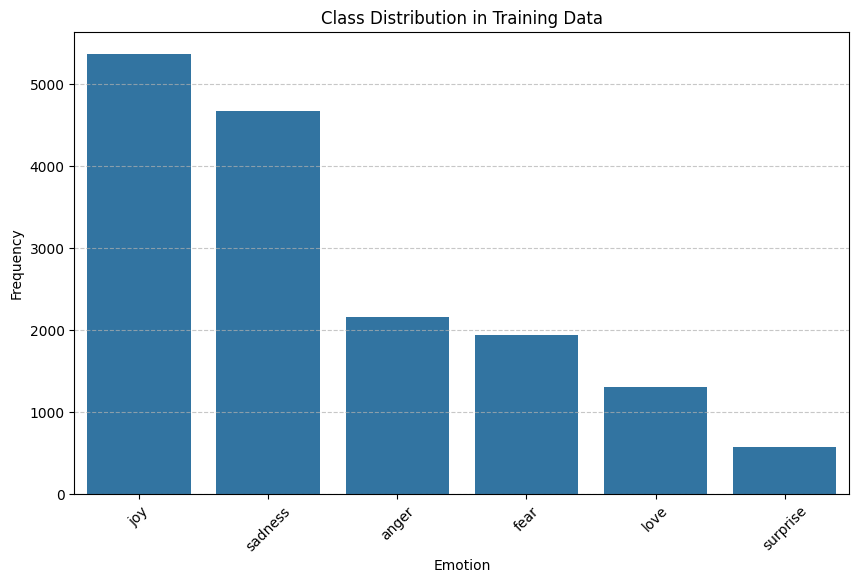

In [ ]:

plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution in Training Data')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Interpretation

From the statistics and plot, we can clearly see that the classes are significant imbalanced, with the class `joy` and `sadness` being much more frequent than other classes like `surprise` and `love`. Addressing this imbalance will be crucial for developing fair and effective models.

#### Strategies to address class imbalance:

We can use few practical steps to address the class imbalance:
1. Resampling:
   1. Oversampling the minority classes: This involves replicating the samples from the minority classes. This method is effective but can lead to overfitting.
   2. Undersampling the majority classes: This reduces the size of the majority classes to match the minority classes. However, this method can lead to a loss of valuable data.
   
2. Synthetic Data Generation:
   1. SMOTE (Synthetic Minority Over-sampling Technique): This technique generates synthetic samples rather creating exact copies, helping to introduce variability.

We will use SMOTE to address the class imbalance in our dataset after preprocessing the data.

## 1.2. Preprocessing

The data needs to be cleaned and standardized to make it suitable for modeling.

Text Cleaning:

- Convert text to lowercase to ensure uniformity.
- Remove URLs and usernames from the text.
- Remove any punctuation as it generally does not add to sentiment analysis.
- Remove stopwords to focus on more meaningful words.

In [ ]:
def clean_text(text):
    """Function to preprocess text data:
    - Convert to lowercase
    - Remove URLs.
    - Remove username.
    - Remove punctuation.
    - Remove stopwords

    Args:
        text (str): input text to be preprocessed
    """

    # Lowercase
    text = text.lower()

    # Remove URLs
    url_pattern = re.compile(r'https?://\S+|WWW\.\S+')
    text = url_pattern.sub(r'', text)

    # Remove usernames
    text = re.sub(r'@\w+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [ ]:
# Apply the function to the text column of the dataframe
train_data['text'] = train_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)
validation_data['text'] = validation_data['text'].apply(clean_text)

### 1.3. Tokenization and Vectorization

Tokenization is the process of converting text into tokens (words, characters, or subwords), while vectorization is the method of turning those tokens into numberical values that can be used as input machine learning models.

For this task, we gonna use Keras Tokenizer
1. Initialize the Tokenize: This converts words into integer indices.
2. Fit the Tokenizer on the data: This tokenizer learns the mapping from words to indices using the traing data.
3. Transform Texts to Sequences: Convert texts into lists of integers.
4. Padding the Sequences: Standardize the length of sequences so that they can be used in models that expect input sequences of the same length.


### 1.3.1. Analyze the dataset's vocabulary

Since the choice of vocabulary size can significantly impact model performance. We want to systematically determine the number of words we need for initialized the tokenizer. This step calculates the total number of unique words in the training data, providing a base to decide how many words we want to include in our model's vocabulary.

In [ ]:
# Initialize the tokenizer without limiting num_words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

# Get the total number of unique words in the dataset
total_vocab = len(tokenizer.word_index) + 1 # TODO: Plus one for padding token
print("Total words in vocabulary:", total_vocab)


Total words in vocabulary: 15065


In [ ]:
# Count the number of times each word appears in the dataset
word_counts = tokenizer.word_counts
sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Determine a threshold for minimum word frequency (e.g., words that appear at least twice)
min_word_freq = 2
vocab_size = sum(1 for word, count in sorted_words if count >= min_word_freq)

print("Adjusted vocabulary size:", vocab_size)


Adjusted vocabulary size: 7254


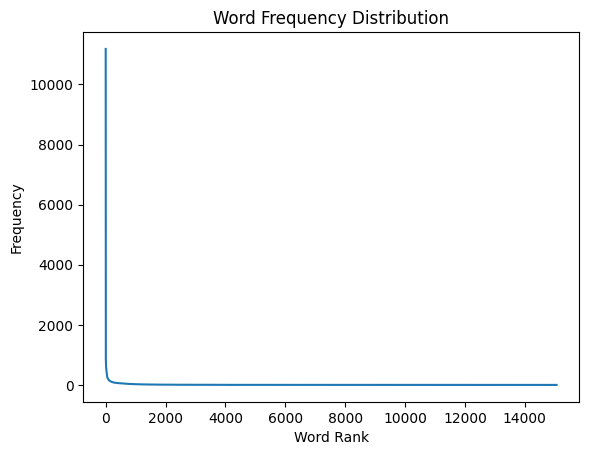

In [ ]:
# Plot word frequency distribution
frequencies = [count for word, count in sorted_words]
plt.plot(frequencies)
plt.title('Word Frequency Distribution')
plt.xlabel('Word Rank')
plt.ylabel('Frequency')
plt.show()


### Interpretation

The plot shows a steep drop-off in the word frequency distribution, which can be a good cutoff for setting `num_words` - words beyond this point occur infrequently and may contribute less to understanding the text.

By dynamically setting the tokenizer's vocabulary size based on actual data insights, ensuring the model is neither overloaded with too many rare words nor missing out on important ones, leading to more efficient and effective training.

### Reinitialize the Tokenizer with the new `num_words` parameter

We re-initialize the tokenizer with the new `num_words` value. And also apply the same tokenizer that fitted on the training data to our validation and test data. This step ensures that the tokenization scheme remains consistent across all datasets.

Since most neural networks require inputs of the same length, we'll pad the sequences.

In [ ]:
# Reinitialize the tokenizer with the adjusted vocabulary size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_data['text'])

# Tokenize the training, validation and test data
train_sequences = tokenizer.texts_to_sequences(train_data['text'])
validation_sequences = tokenizer.texts_to_sequences(validation_data['text'])
test_sequences = tokenizer.texts_to_sequences(test_data['text'])

In [ ]:
# Get max length from training data
max_length = max(len(seq) for seq in train_sequences)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

### 1.5. Class Balancing

After processing the dataset, we need to solve the class imbalance problem by using techniques since the problem can significantly impact the performance of the model towards more frequent classes.

We gonna use a technique called SMOTE (Synthetic Minority Over-sampling Technique) which is a popular method to artificially augment the training dataset by creating synthetic samples rather than by over-sampling.

Since SMOTE works directly on numerical data, that's why we apply it after the tokenization and padding but before feeding the data into our neural network model.

#### 1. Convert labels to numeric form

Since our labels acre categorical (text), we first need to convert them to a numerical format. We gonna use the LabelEncoder class from scikit-learn to do this:

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
train_labels = label_encoder.fit_transform(train_data['emotion'])
validation_labels = label_encoder.transform(validation_data['emotion'])
test_labels = label_encoder.transform(test_data['emotion'])

#### 2. Apply SMOTE

Now, apply SMOTE to the training data. One important thing to note is that it's crucial to apply SMOTE only to the training data to prevent information leakage and ensure that validation and test sets reflect true, real world scenarios.

In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE (only apply for training data)
train_padded_resampled, train_labels_resampled = smote.fit_resample(train_padded, train_labels)

In [ ]:
# Count the occurrences of each class in the resampled labels
unique, counts = np.unique(train_labels_resampled, return_counts=True)
new_distribution = dict(zip(unique, counts))
print("New class distribution:", new_distribution)

New class distribution: {0: 5362, 1: 5362, 2: 5362, 3: 5362, 4: 5362, 5: 5362}


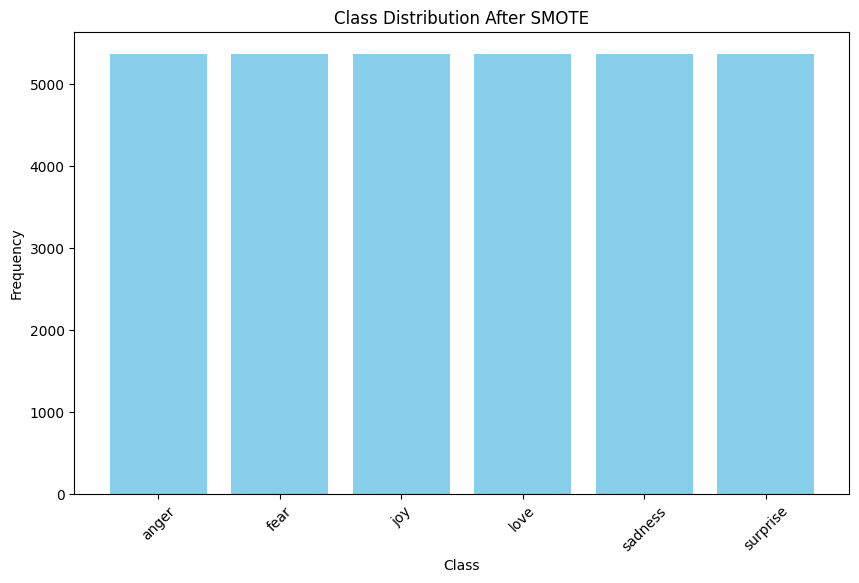

In [ ]:
# Classes on the x-axis and counts on the y-axis
plt.figure(figsize=(10, 6))
plt.bar(range(len(new_distribution)), list(new_distribution.values()), align='center', color='skyblue')
plt.xticks(range(len(new_distribution)), [label_encoder.inverse_transform([item])[0] for item in list(new_distribution.keys())], rotation=45)
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

## Part 2. Model Building

## 2.1. Fully Connected Neural Network

This type of model uses dense layers and possibly dropout layers to prevent over-fitting.

In [ ]:
num_classes = len(np.unique(train_labels_resampled))
embedding_dim = 100
print("Number of classes:", num_classes)
print("Max length:", max_length)

Number of classes: 6
Max length: 34


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


model_fcnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_fcnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_fcnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 100)           725400    
                                                                 
 flatten (Flatten)           (None, 3400)              0         
                                                                 
 dense (Dense)               (None, 128)               435328    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 3

## 2.2. Recurrent Neural Network, based on LSTM or GRU

This model helps capture the sequence patterns in the text data, which is useful for understanding the context in sentences or phrases.

In [ ]:
from tensorflow.keras.layers import LSTM

model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 34, 100)           725400    
                                                                 
 lstm (LSTM)                 (None, 34, 128)           117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 896606 (3.42 MB)
Trainable params: 896606 (3.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 2.3. Fine-tuned Architecture

For fine-tuned model, I used the pre-trained BERT model from HuggingFace's transformers library which can be extremely powerful due to its pretraining on a large corpus of text but turned out the training process is extremely slow and I can't finish on my resources. So I try Universal Sentence Encoder on TF Hub.

In [ ]:
# Load the Universal Sentence Encoder's TF Hub module
hub_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                           input_shape=[], dtype=tf.string, trainable=True)

# Build the model
model_use = Sequential([
    hub_layer,
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_use.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


### Training the models

Each model will be trained on the training dataset

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001, verbose=1)
model_checkpoint_fcnn = ModelCheckpoint('best_model_fcnn.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
model_checkpoint_rnn = ModelCheckpoint('best_model_rnn.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
model_checkpoint_use = ModelCheckpoint('best_model_use.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True)

In [ ]:
print('Training the fully-connected neural network\n')
history_fcnn = model_fcnn.fit(
    train_padded_resampled,
    train_labels_resampled,
    epochs=100,
    validation_data=(validation_padded, validation_labels),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, model_checkpoint_fcnn],
)

print('Training the recurrent neural network\n')
history_rnn = model_rnn.fit(
    train_padded_resampled,
    train_labels_resampled,
    epochs=100,
    validation_data=(validation_padded, validation_labels),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, model_checkpoint_rnn],
)

print('Training the bert\n')
history_use = model_use.fit(
    train_data['text'],
    train_labels,
    epochs=10,
    validation_data=(validation_data['text'], validation_labels),
    callbacks=[early_stopping, reduce_lr, tensorboard_callback, model_checkpoint_use]
)

Training the fully-connected neural network

Epoch 1/100
1006/1006 [==============================] - ETA: 0s - loss: 1.6667 - accuracy: 0.2819
Epoch 1: val_accuracy improved from -inf to 0.68700, saving model to best_model_fcnn.keras
1006/1006 [==============================] - 24s 21ms/step - loss: 1.6667 - accuracy: 0.2819 - val_loss: 1.0719 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 2/100
1006/1006 [==============================] - ETA: 0s - loss: 1.2924 - accuracy: 0.5077
Epoch 2: val_accuracy improved from 0.68700 to 0.78200, saving model to best_model_fcnn.keras
1006/1006 [==============================] - 6s 6ms/step - loss: 1.2924 - accuracy: 0.5077 - val_loss: 0.7929 - val_accuracy: 0.7820 - lr: 0.0010
Epoch 3/100
1006/1006 [==============================] - ETA: 0s - loss: 1.0341 - accuracy: 0.6173
Epoch 3: val_accuracy did not improve from 0.78200
1006/1006 [==============================] - 4s 4ms/step - loss: 1.0341 - accuracy: 0.6173 - val_loss: 0.8745 - val_accuracy: 0.

## 2.4. Comparison of architectures

In [ ]:
def plot_training_history(history, title='Model Training History'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')  # 'b-' for blue lines
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'ro-', label='Training Loss')  # 'ro-' for red circle markers connected by lines
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')  # 'r-' for red lines
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

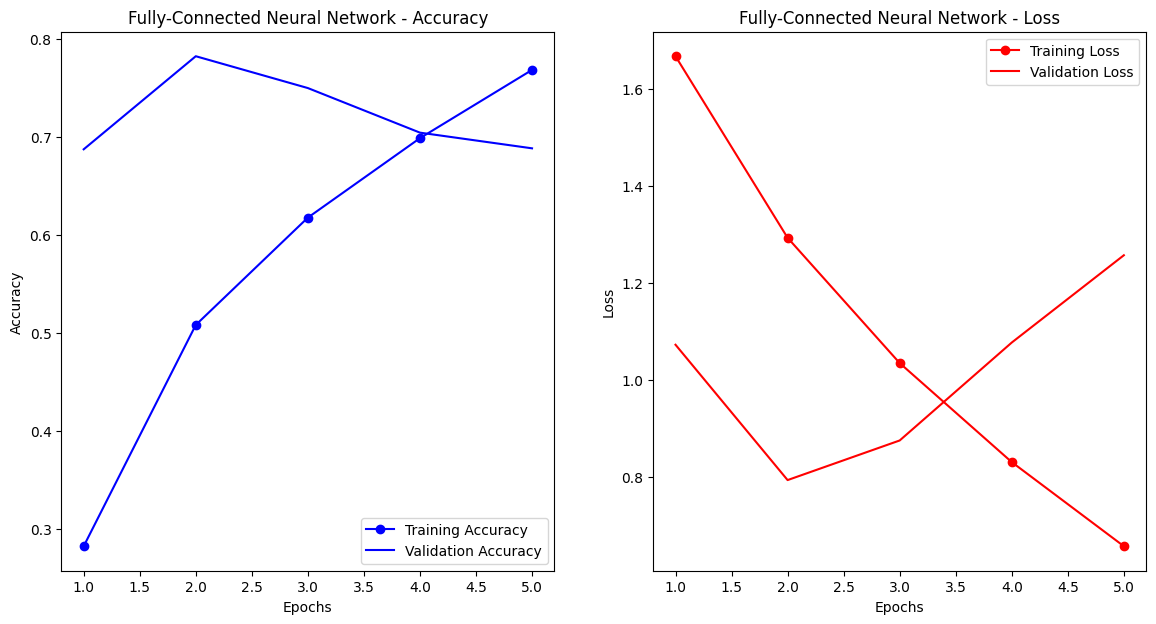

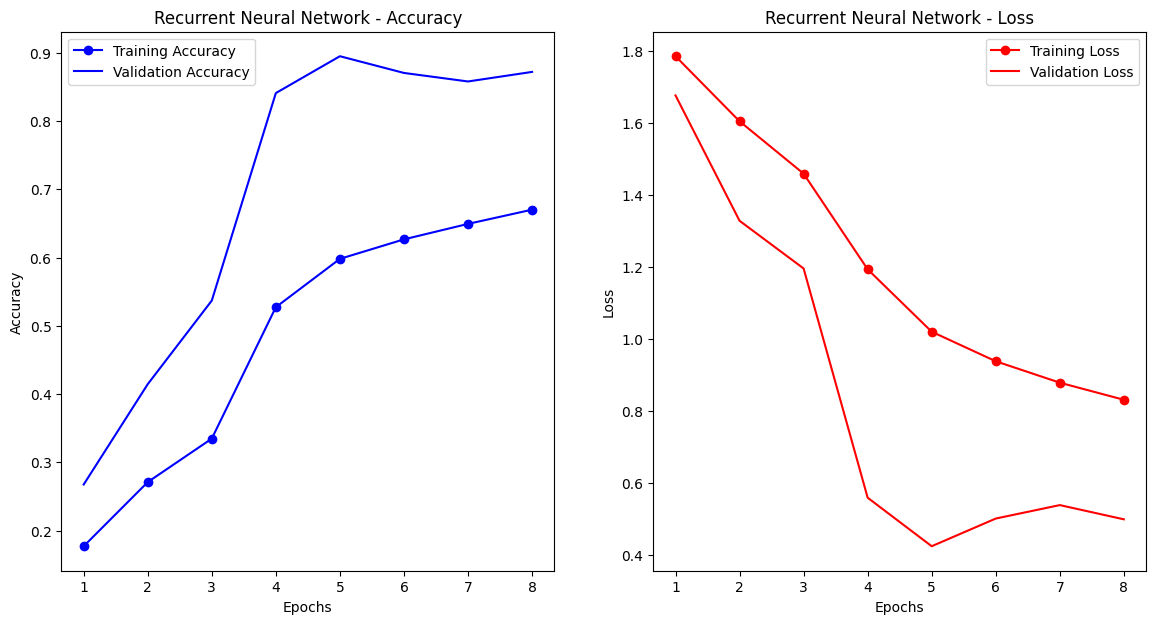

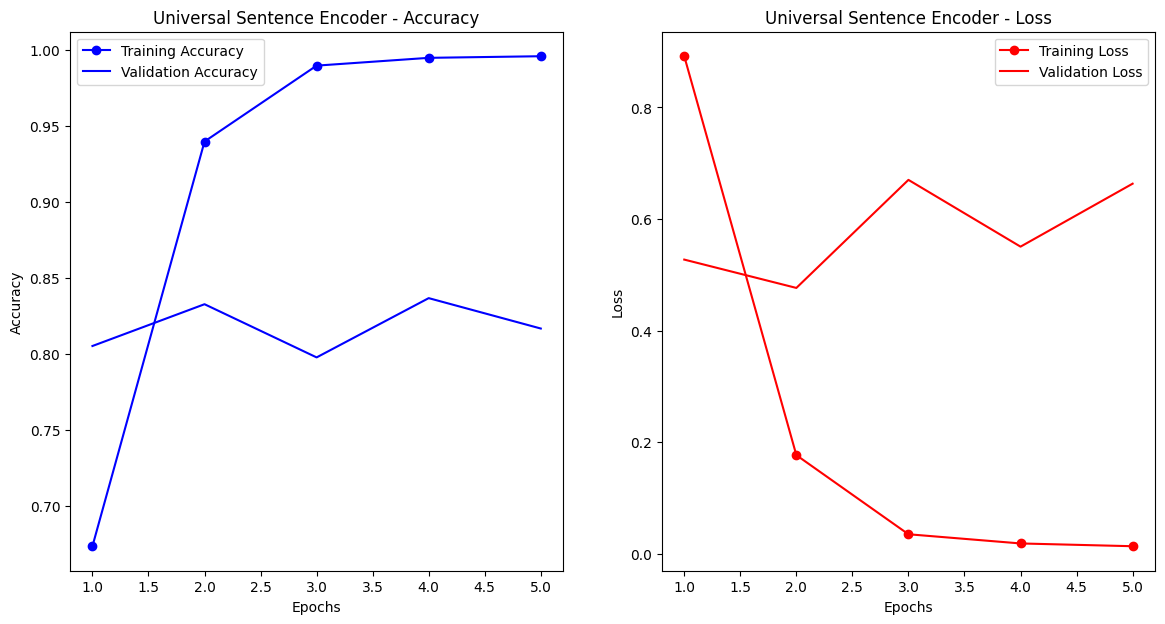

In [ ]:
plot_training_history(history_fcnn, 'Fully-Connected Neural Network')
plot_training_history(history_rnn, 'Recurrent Neural Network')
plot_training_history(history_use, 'Universal Sentence Encoder')


### Results comparison and Interpretation

1. Fully-Connected Neural Network (FCNN)

    The FCNN model showed rapid improvements in the initial epochs, where validation accuracy peaked at around 78.2% by the second epoch. However, subsequent epochs did not maintain this performance, suggesting potential overfitting as the training loss decreased but the validation loss increased.

    Concerns: The validation loss increased from epoch 3 onwards, indicating that the model may be too complex or not regularized enough for the generalization needed on this task. The accuracy also started to decrease after peaking, confirming a divergence between training and validation sets.

2. Recurrent Neural Network (RNN)
    
    The RNN model, utilizing LSTM units, improved steadily over the training period. This model achieved a high validation accuracy of approximately 89.5% by the fifth epoch, showing strong learning capabilities over sequences compared to the FCNN.

    Advantages: The RNN managed to handle the sequential nature of the text data effectively, demonstrating significant gains in both accuracy and loss reduction on validation data. The performance suggests good generalization from training to unseen data.

    Stability: Despite initial low performance, the model quickly adapted and showed consistent improvement, indicating robustness in learning from the data dynamics.

3. Universal Sentence Encoder (USE)

    The USE model, leveraging transfer learning with a pre-trained text embedding layer, showed the most robust performance. It quickly reached a high validation accuracy of about 83.65%, and although it saw some fluctuations in validation accuracy, it generally maintained high performance.

    Efficiency: USE demonstrated strong capabilities in text representation, enabling effective learning with fewer epochs compared to the other models. It also managed a balance between accuracy and loss, as seen in its competitive validation scores.

    Limitations: Despite its strengths, the USE model's performance plateaued quickly, suggesting potential limits in adapting the pre-trained embeddings fully to the specific nuances of the sentiment analysis task at hand.

### Overall Interpretation and Recommendations:

For generalization, the RNN and USE models showed better generalization on validation data compared to the FCNN. This suggests their architectures are more suited to the complexities of natural language processing, particularly for sentiment analysis.

About training dynamics, tje USE and RNN models were more stable and consistent in performance across epochs, whereas the FCNN displayed potential overfitting issues.

We can conclude that for model selection if the primary concern is accuracy and robust handling of sequential data, the RNN model is highly recommended. For quicker deployment with competitive performance, using the USE model would be advantageous due to its use of powerful pre-trained components.

For future improvements, I consider experimenting with:
- additional regularization techniques,
- hyperparameter tuning,
- and possibly more sophisticated architectures like transformers (with better resources than the one I have now or deeper LSTM networks for the FCNN and RNN models.
- for the USE model, I think exploring different configurations of the top layers and fine-tuning on the specific dataset could further enhance its performance.



---

*Thank you very much for reading.*